In [39]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.integrate import cumulative_simpson
import numpy as np
import lisa
from cmcrameri import cm

In [2]:
import utils.load_grid as lg
from proteus.utils.constants import R_earth

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [4]:
pgrid_dir = "data/shared/l98d_submitted/l98d_habrok3/"
cases = lg.get_cases(pgrid_dir)

In [5]:
# Collect netcdf files
stts = lg.get_statuses(pgrid_dir)
# endn = lg.load_netcdfs_end(cases)

# Configuration variables
cvars = lg.load_configs(cases)
ncases = len(cases)

# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

print("Done")

Helpfiles: 100%|██████████| 900/900 [01:00<00:00, 14.89it/s]


Done


In [6]:
count_solid = 0
count_steady = 0

for i in range(ncases):
    match stts[i]:
        case 11: count_steady += 1
        case 10: count_solid += 1

print("Total cases: %d"%ncases)
print("Steady state count : %d (%.3f %%)" % (count_steady , count_steady/ncases*100.0))
print("Solidified count   : %d (%.3f %%)" % (count_solid , count_solid/ncases*100.0))

Total cases: 900
Steady state count : 0 (0.000 %)
Solidified count   : 540 (60.000 %)


In [153]:
def plot_var_vs_time(y_key, y_lbl, y_scl=1.0,
                            z_key="", z_lim=None, z_lbl=None,
                            legend=False, cbar='right',
                            default_col='black', alpha=0.5, scatter=False, lw=1.0,
                            logx=False, logy=True, ylims=None, min_time=1e4):

    y_key = str(y_key).strip()
    y_key_lower = y_key.lower()

    # options
    if legend:
        col = None
    else:
        col = default_col
    icrop = 4

    fig,ax = plt.subplots(1,1, figsize=(6,4.5))

    if ncases > 10:
        cmap = cm.batlow
    else:
        cmap = plt.get_cmap("tab10")

    sm = None
    if z_lim is not None:
        norm = mpl.colors.Normalize(vmin=z_lim[0], vmax=z_lim[1])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

    # for all cases
    min_time = float(min_time)/1e9
    max_time = min_time*1.1
    show_legend = bool(legend)
    zmin, zmax = 0.0,0.0
    for i in range(ncases):

        x_arr = np.array(helps[i]["Time"])[icrop:] / 1e9
        max_time = max(max_time, np.amax(x_arr))

        casename = cases[i].split("/")[-1]
        z_val = None
        if len(z_key) > 0:
            z_val = lg.descend_get(cvars[i],z_key)
            zmin = min(zmin, z_val)
            zmax = max(zmax, z_val)
            try:
                lbl = "%.3f"%z_val
            except:
                lbl = str(z_val)
        else:
            lbl = casename

        if legend or cbar:
            if z_lim is not None:
                col = sm.to_rgba(z_val)
            else:
                col = cmap(i/(ncases-1))

        # handle key
        if y_key_lower in ["bar", "vmr"]:

            for v in lg.volatile_species:
                if y_key_lower == "bar":
                    key = v+"_atm_bar"
                elif y_key_lower == "vmr":
                    key = v+"_vmr"
                y_arr = np.array(helps[i][key])[icrop:]

                if np.all(y_arr < 1.0e-30):
                    continue
                if scatter:
                    ax.scatter(x_arr, y_arr, c=col, label=lbl, alpha=alpha, s=1)
                else:
                    ax.plot(x_arr, y_arr, c=col, label=lbl, alpha=alpha, lw=lw)

        else:

            if y_key_lower == "esc_rate_integ":
                e_arr = np.array(helps[i]["esc_rate_total"])[icrop:] * y_scl
                t_arr = np.array(helps[i]["Time"])[icrop:]

                y_arr = cumulative_simpson(e_arr, x=t_arr)
                y_arr = np.append(y_arr, y_arr[-1])

                ax.plot(t_arr, y_arr, c=col, alpha=alpha)
            else:
                y_arr = np.array(helps[i][y_key])[icrop:] * y_scl

            if scatter:
                ax.scatter(x_arr, y_arr, c=col, alpha=alpha, s=1, label=lbl)
            else:
                ax.plot(x_arr, y_arr, c=col, alpha=alpha, lw=lw, label=lbl)


    # configure plot
    ax.set_xlabel("Time [Gyr]")
    ax.set_xlim(min_time, max_time)
    if logx:
        ax.set_xscale("log")
    else:
        ax.set_xlim(left=0, right=max_time)
        ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
        ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.2))

    ax.set_ylabel(y_lbl)
    if logy:
        ax.set_yscale("log")
    if y_key == "vmr":
        ax.set_ylim(1e-7, 1.1)

    if not (ylims == None):
        ax.set_ylim(ylims[0], ylims[1])

    # final things
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),
                    ncols=max(int(ncases/10),1), title=z_key)

    if cbar and z_key:
        if z_lbl is None:
            z_lbl = z_key
        fig.colorbar(sm, ax=ax, location=cbar, label=z_lbl)

    print(f"{z_key} min: {zmin}")
    print(f"{z_key} max: {zmax}")

    ax.grid(alpha=0.5, which='major')
    ax.grid(alpha=0.2, which='minor')

    fig.tight_layout()
    plt.show()



delivery.elements.H_ppmw min: 0.0
delivery.elements.H_ppmw max: 16000.0


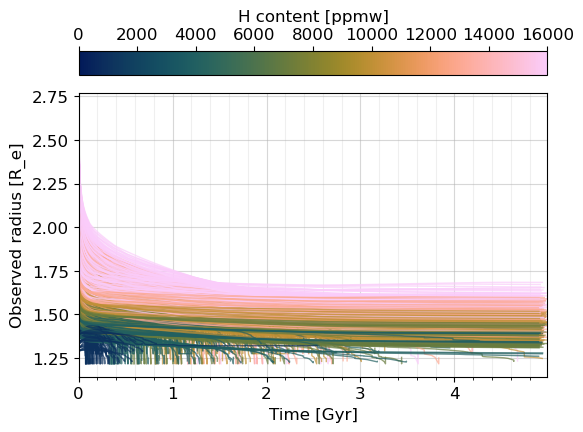

delivery.elements.H_ppmw min: 0.0
delivery.elements.H_ppmw max: 16000.0


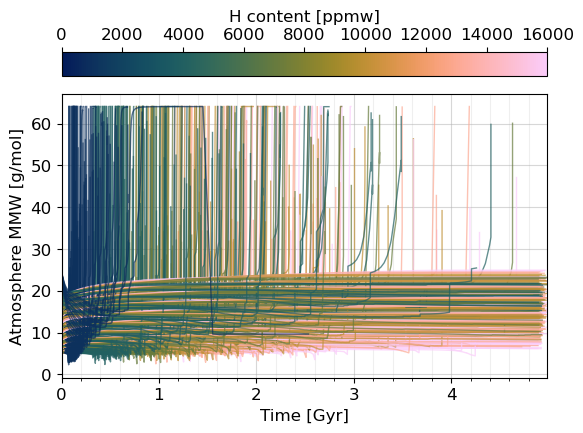

In [154]:
plt.close("all")

params = {
    "alpha"     : 0.7,
    "lw"        : 1.0,
    "logx"      : False,
    "scatter"   : False,
    "legend"    : False,
    "cbar"      : 'top'
}

# params["z_key"]=  "escape.zephyrus.efficiency"
# params["z_lim"]=  (0.0, 0.3)

params["z_key"]=  "delivery.elements.H_ppmw"
params["z_lim"]=  (0, 16000)
params["z_lbl"]=  "H content [ppmw]"

# params["z_key"]=  "struct.corefrac"

# params["z_key"]=  "atmos_clim.agni.spectral_bands"

# params["z_key"]=  "orbit.eccentricity"

plot_var_vs_time("R_obs",           "Observed radius [R_e]",   **params, logy=False, y_scl=1/R_earth)
plot_var_vs_time("atm_kg_per_mol",  "Atmosphere MMW [g/mol]",  **params, logy=False, y_scl=1e3)

# plot_var_vs_time("H2_vmr",         "H2 vmr [%]",               **params, logy=False, y_scl=1e2)
# plot_var_vs_time("T_surf",          "Surface temperature [K]", **params, logy=False)
# plot_var_vs_time("P_surf",          "Pressure [bar]",          **params, logy=True)
# plot_var_vs_time("esc_rate_integ",  "Integrated escape [kg]",  **params, logy=False)
# plot_var_vs_time("Phi_global",      "Global melt fraction",    **params, logy=False, ylims=(0,100), y_scl=100)
# plot_var_vs_time("F_atm",           "Net flux [W m-2]",        **params, logy=True)
# plot_var_vs_time("F_olr",           "OLR [W m-2]",             **params, logy=True)
# plot_var_vs_time("F_tidal",         "Tides [W m-2]",           **params, logy=False)


In [195]:
def plot_isochrone(times,
                    x_key, y_key,
                    x_lbl, y_lbl,
                    x_scl=1.0, y_scl=1.0,
                    logx=False, logy=False,
                    x_tru=None, y_tru=None,
                    alpha=0.5, legend=True, panel=None):

    y_key = str(y_key).strip()
    x_key = str(x_key).strip()

    times = list(times)

    fig,ax = plt.subplots(1,1, figsize=(5.8,2.5))

    # truth
    c = 'k'
    ls= 'dashed'
    if x_tru:
        ax.axvline(x=x_tru, color=c, ls=ls, zorder=20)
    if y_tru:
        ax.axhline(y=y_tru, color=c, ls=ls, zorder=20)
    if x_tru or y_tru:
        ax.plot([],[],color=c, ls=ls, label='Obs. estimated')
    if x_tru and y_tru:
        ax.scatter([x_tru], [y_tru], color=c, marker='s', s=22, edgecolors='none', zorder=20)

    # for all times
    markers = ['o','s','P','X','*','D',]
    for it,t in enumerate(times):

        # for all cases
        x_arr = []
        y_arr = []
        t_arr = []
        for i in range(ncases):
            i_close = np.argmin(np.abs(t - helps[i]["Time"]))
            x_arr.append( helps[i][x_key].iloc[i_close] * x_scl )
            y_arr.append( helps[i][y_key].iloc[i_close] * y_scl )
            t_arr.append( helps[i]["Time"].iloc[i_close] / 1e9)

        mask = np.argsort(x_arr)
        x_arr = np.array(x_arr)[mask]
        y_arr = np.array(y_arr)[mask]

        m = markers[it]
        lbl = r"$t \approx$" + "%.2f Gyr"%float(t/1e9)

        ax.scatter(x_arr, y_arr, alpha=alpha, marker=m, edgecolors='none', s=15, label=lbl, zorder=2, rasterized=False)

    # configure plot
    ax.set_xlabel(x_lbl)
    if logx:
        ax.set_xscale("log")
    ax.set_ylabel(y_lbl)
    if logy:
        ax.set_yscale("log")

    # final things
    if legend:
        leg = ax.legend(framealpha=1.0)
    ax.grid(alpha=0.5, which='major', zorder=-2)
    ax.grid(alpha=0.2, which='minor', zorder=-2)
    if panel:
        ax.text(0.01, 0.95, panel, transform=ax.transAxes, zorder=99, fontsize=14, va='top', ha='left', fontweight='bold',)

    fig.tight_layout()
    plt.show()

    fig.savefig(f"output/fig_chrone_{x_key}_{y_key}.pdf", bbox_inches='tight', dpi=300)

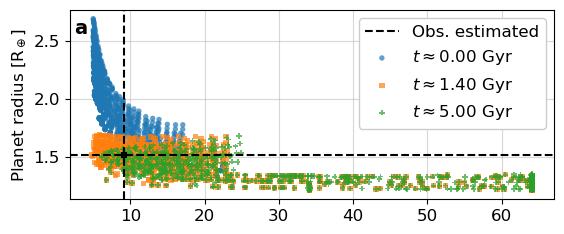

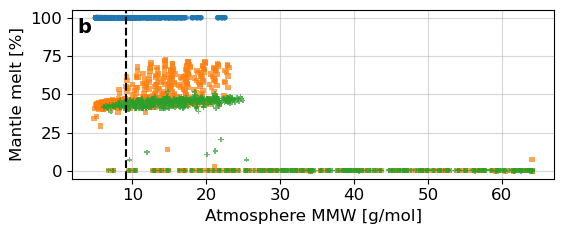

In [196]:
times = np.array([0.0, 1.4, 5.0]) * 1e9

plot_isochrone(times,
                "atm_kg_per_mol",         "R_obs",
                "", r"Planet radius [R$_\oplus$]",
                x_tru=9.18, y_tru=1.521,
                x_scl=1e3, y_scl=1/R_earth,
                alpha=0.7, panel='a')

plot_isochrone(times,
                "atm_kg_per_mol",         "Phi_global",
                "Atmosphere MMW [g/mol]", r"Mantle melt [%]",
                x_tru=9.18, y_tru=None,
                x_scl=1e3, y_scl=100.0,
                alpha=0.7, legend=False, panel='b')